In [1]:
import numpy as np
import scanpy as sc
import torch

import matplotlib.pyplot as plt
from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import TRANVAE
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
unlabeled_strat = "batch"
cells_per_ct = 2000

# Model Params
latent_dim = 30
use_mmd = False

# Training Params
alpha_epoch_anneal = 1e6
eta = 1
tau = 0
clustering_res = 0.5
labeled_loss_metric = "dist"
unlabeled_loss_metric = "dist"
class_metric = "dist"

early_stopping_kwargs = {
    "early_stopping_metric": "val_classifier_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

cell_type_key = ["cell_type"]

In [4]:
DATA_DIR = '../data'
adata = sc.read(
    f'{DATA_DIR}/benchmark_pancreas_shrinked.h5ad'
)
condition_key = 'study'
reference = ["inDrop1", "inDrop2", "inDrop3", "inDrop4", "fluidigmc1", "smartseq2", "smarter"]
query = ["celseq", "celseq2"]


In [5]:
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')

In [6]:
source_adata = adata[adata.obs.study.isin(reference)].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [7]:
tranvae = TRANVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 7
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 30
Decoder Architecture:
	First Layer in, out and cond:  30 128 7
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [8]:
tranvae.train(
    n_epochs=100,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=80,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████████████████████| 100.0%  - val_loss: 1000.6271972656 - val_trvae_loss: 999.2483354048 - val_classifier_loss: 1.3788590756 - val_labeled_loss: 1.3788590756
Saving best state of network...
Best State was in Epoch 96


In [9]:
ref_path = f'../pr/ref_model'
tranvae.save(ref_path, overwrite=True)

In [10]:
tranvae.model.n_cell_types

14

In [11]:
data_latent = tranvae.get_latent(x=source_adata.X, c=source_adata.obs[condition_key])
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = source_adata.obs[condition_key].tolist()
adata_latent.obs['cell_type'] = source_adata.obs['cell_type'].tolist()

In [12]:
landmarks = tranvae.get_landmarks_info()
full_latent = adata_latent.concatenate(landmarks, batch_key=None)

In [13]:
sc.pp.neighbors(adata_latent)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)

... storing 'study' as categorical
... storing 'cell_type' as categorical


[<AxesSubplot:title={'center':'study'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>]

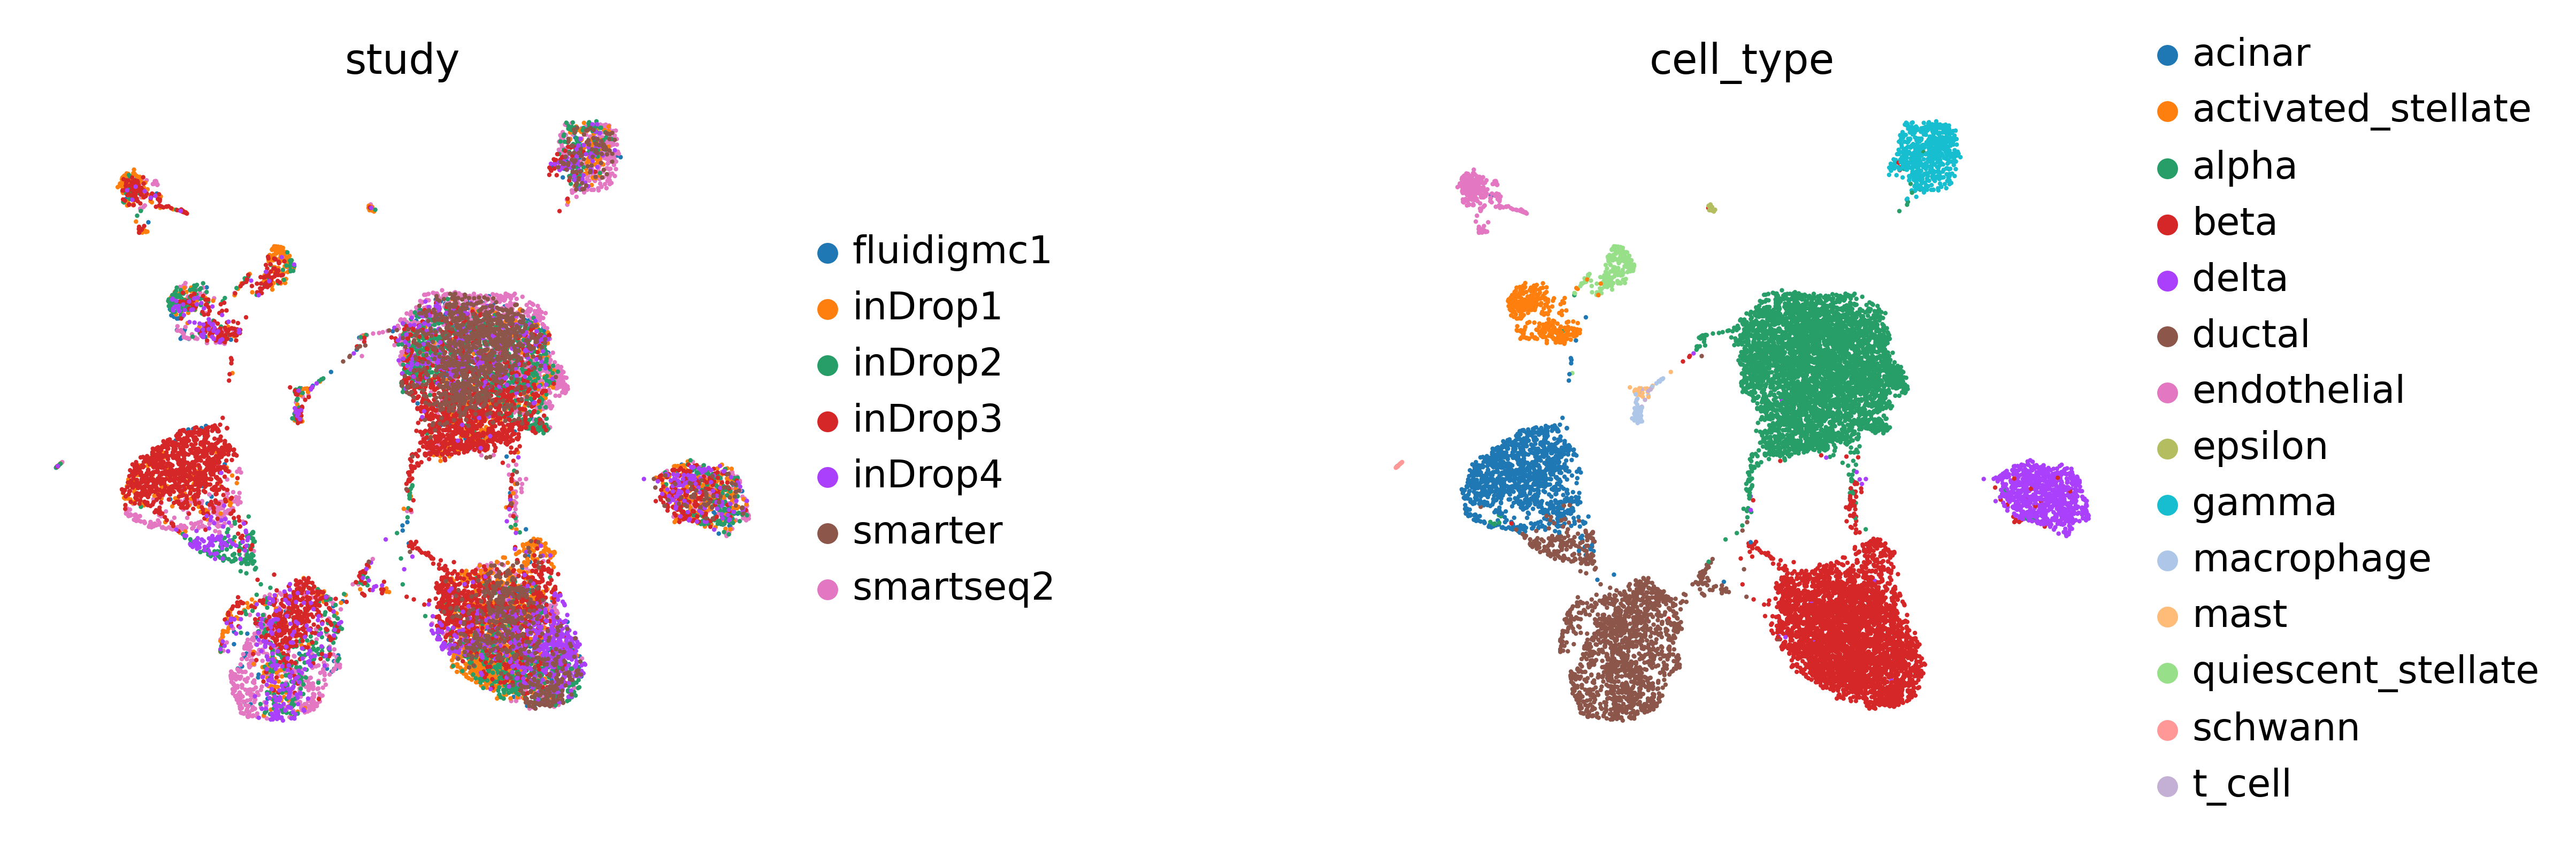

In [14]:
sc.pl.umap(adata_latent,
           color=['study', 'cell_type'],
           frameon=False,
           wspace=0.6,
           show=False
           )


In [15]:
full_latent.obs.study.unique()

array(['fluidigmc1', 'smartseq2', 'inDrop1', 'inDrop2', 'inDrop3',
       'inDrop4', 'smarter', 'Landmark-Set Labeled'], dtype=object)

In [16]:
sc.pp.neighbors(full_latent)
sc.tl.umap(full_latent)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.


Text(0.5, 1.0, 'Landmarks')

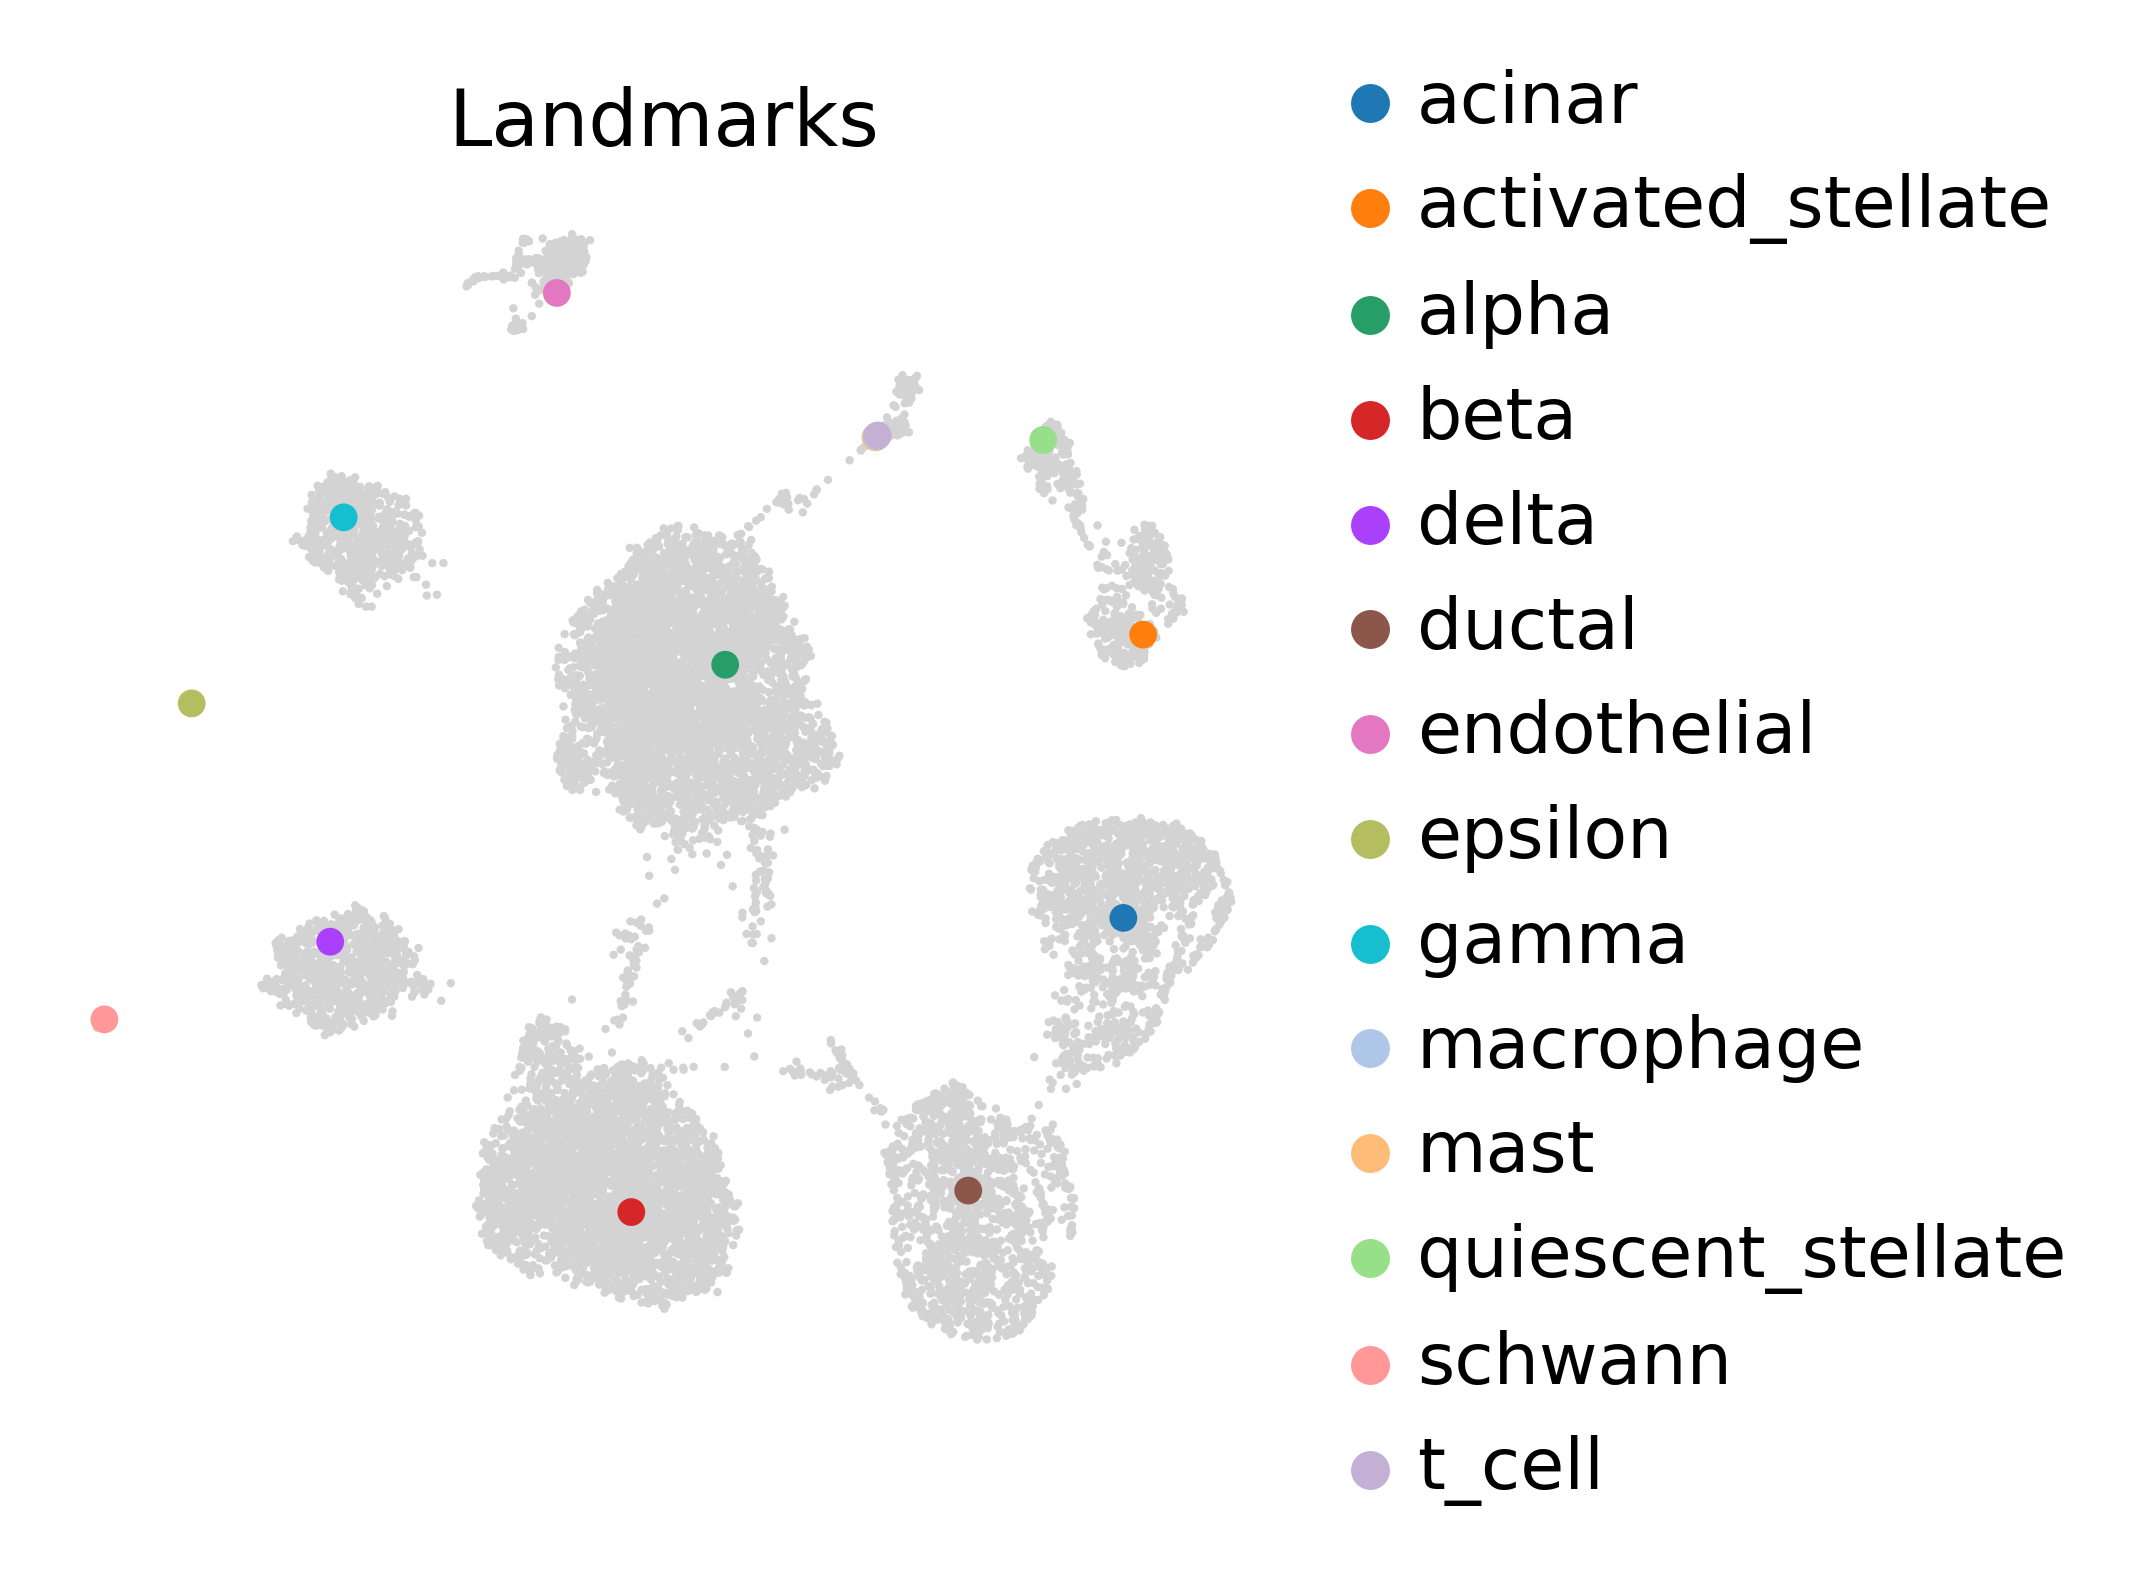

In [17]:
fig, ax = plt.subplots(1, 1)
sc.pl.umap(full_latent, ax=ax, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key].str.contains('Landmark')],
    size=100,
    color='cell_type',
    ax=ax,
    frameon=False,
    show=False
)
ax.set_title('Landmarks')

In [18]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


[<AxesSubplot:title={'center':'study'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'query'}, xlabel='UMAP1', ylabel='UMAP2'>]

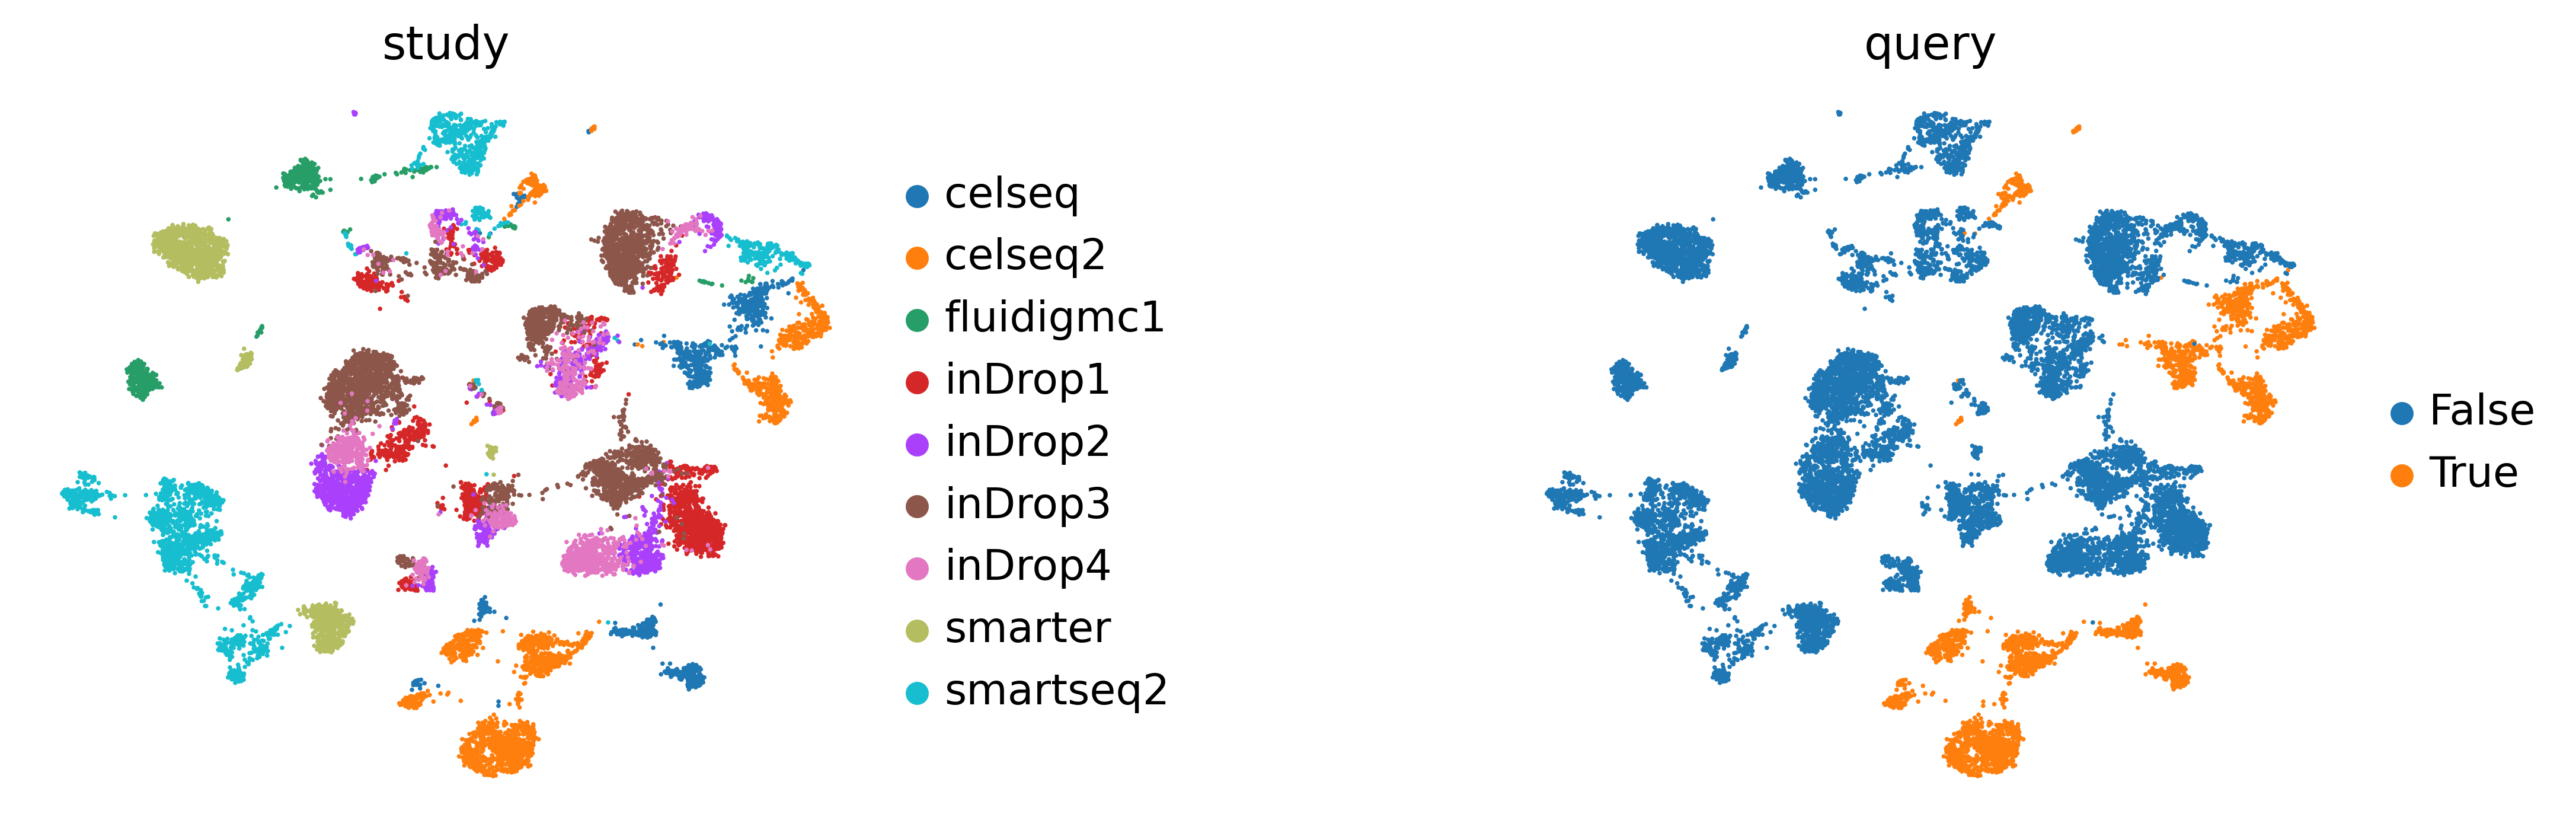

In [19]:
sc.pl.umap(adata,
           color=['study', 'query'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [19]:
tranvae_query = TRANVAE.load_query_data(
    adata=target_adata,
    reference_model=f'../pr/ref_model',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'query'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 30
Decoder Architecture:
	First Layer in, out and cond:  30 128 9
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [20]:
tranvae_query.train(
    n_epochs=100,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=80,
    eta=eta,
    tau=tau,
    weight_decay=0,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████████████████----| 80.0%  - val_loss: 1512.9889322917 - val_trvae_loss: 1512.9889322917
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 10 clusters.
 |████████████████████| 100.0%  - val_loss: 1501.8124593099 - val_trvae_loss: 1501.8123372396 - val_classifier_loss: 0.0001007547 - val_unlabeled_loss: 0.1007546733
Saving best state of network...
Best State was in Epoch 85


In [21]:
data_latent = tranvae_query.get_latent(
    x=adata.X,
    c=adata.obs[condition_key]
)

In [22]:
adata_latent_wquery = sc.AnnData(data_latent)
adata_latent_wquery.obs[condition_key] = adata.obs[condition_key].tolist()
adata_latent_wquery.obs['cell_type'] = adata.obs['cell_type'].tolist()
adata_latent_wquery.obs['query'] = adata.obs['query'].tolist()
adata_latent_wquery.obs['query'] = adata_latent_wquery.obs['query'].astype('category')

In [23]:
sc.pp.neighbors(adata_latent_wquery)
sc.tl.leiden(adata_latent_wquery)
sc.tl.umap(adata_latent_wquery)

... storing 'study' as categorical
... storing 'cell_type' as categorical


[<AxesSubplot:title={'center':'study'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'query'}, xlabel='UMAP1', ylabel='UMAP2'>]

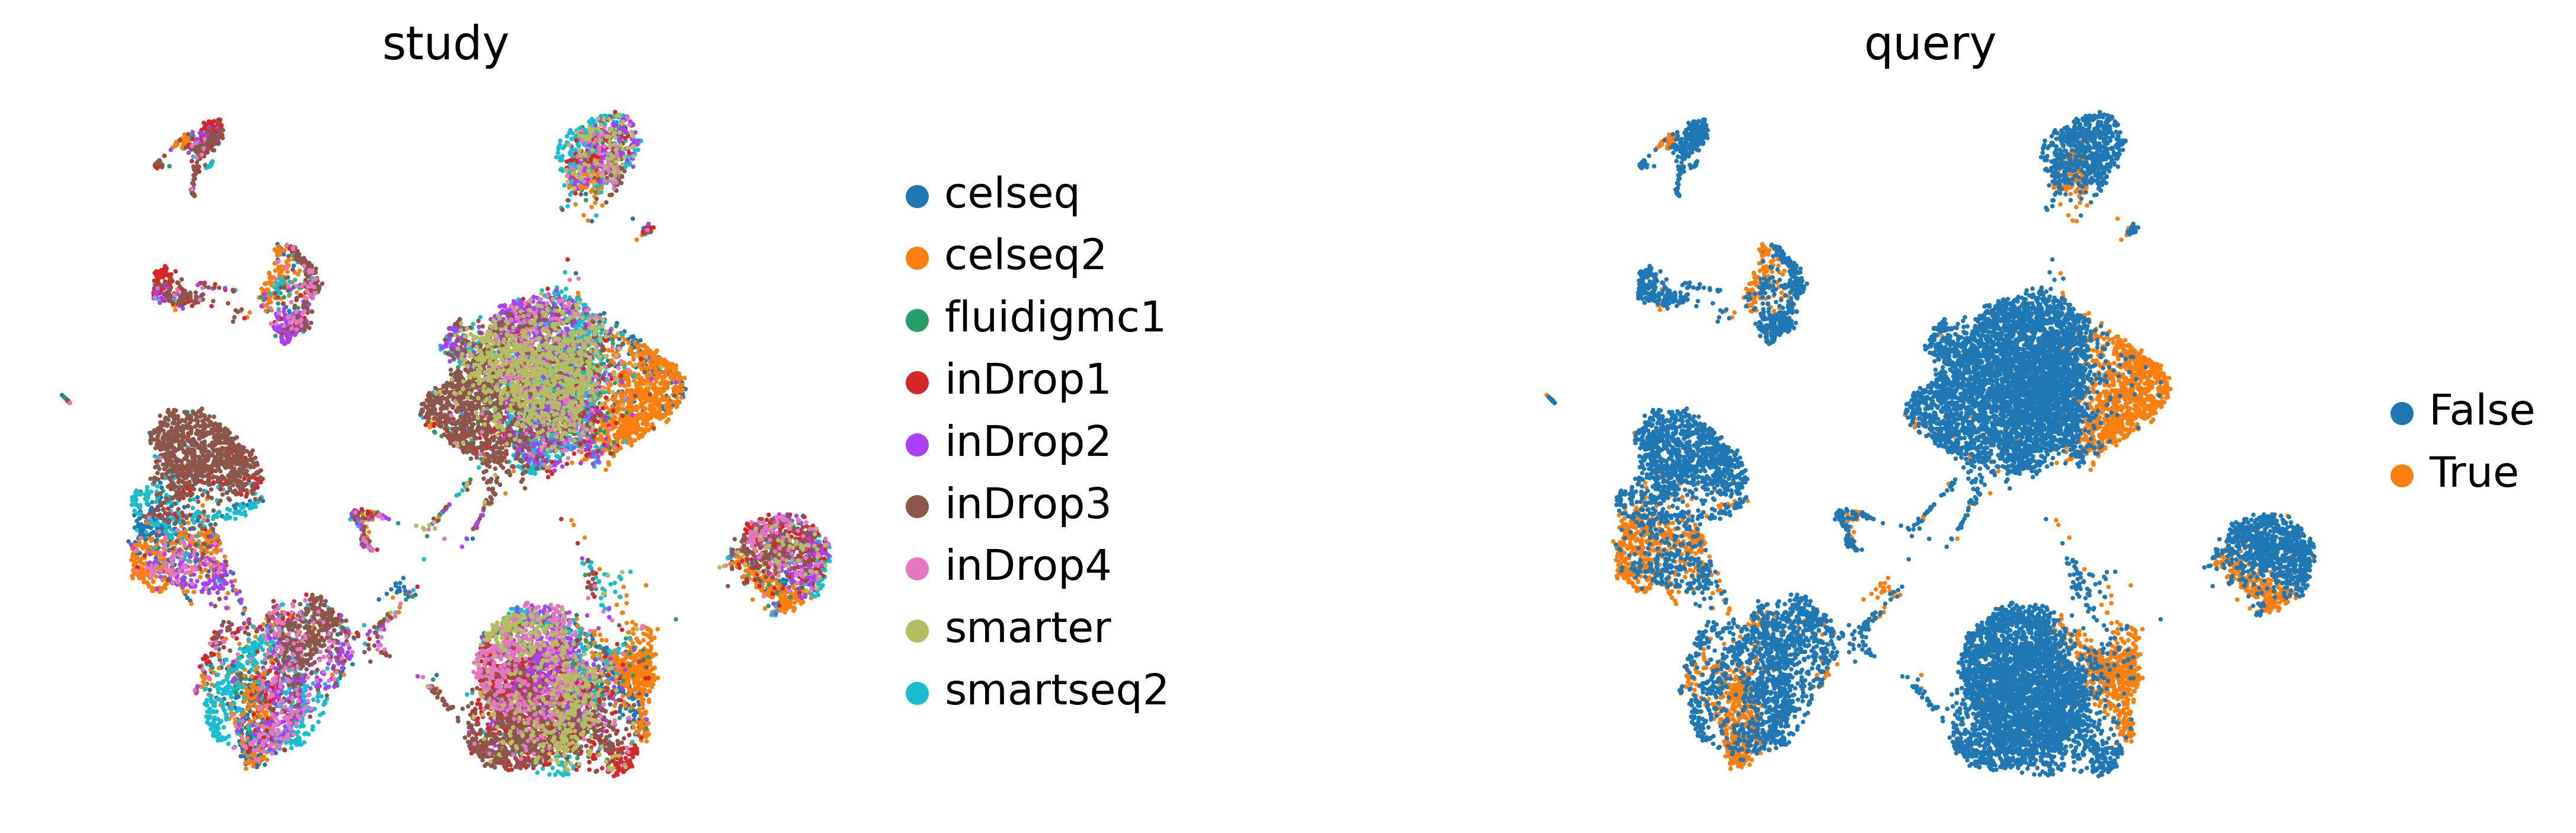

In [24]:
sc.pl.umap(adata_latent_wquery,
           color=['study', 'query'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [25]:
results_dict = tranvae_query.classify(adata.X, adata.obs[condition_key], metric=class_metric)
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]['preds']
    probs = results_dict[cell_type_key[i]]['probs']
    results_dict[cell_type_key[i]]['report'] = classification_report(
        y_true=adata.obs[cell_type_key[i]], 
        y_pred=preds,
        output_dict=True
    )

    correct_probs = probs[preds == adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]

    checks = np.array(len(adata) * ['incorrect'])
    checks[preds == adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent_wquery.obs[cell_type_key[i]] = adata.obs[cell_type_key[i]].tolist()
    adata_latent_wquery.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent_wquery.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()

... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
... storing 'cell_type_bool' as categorical


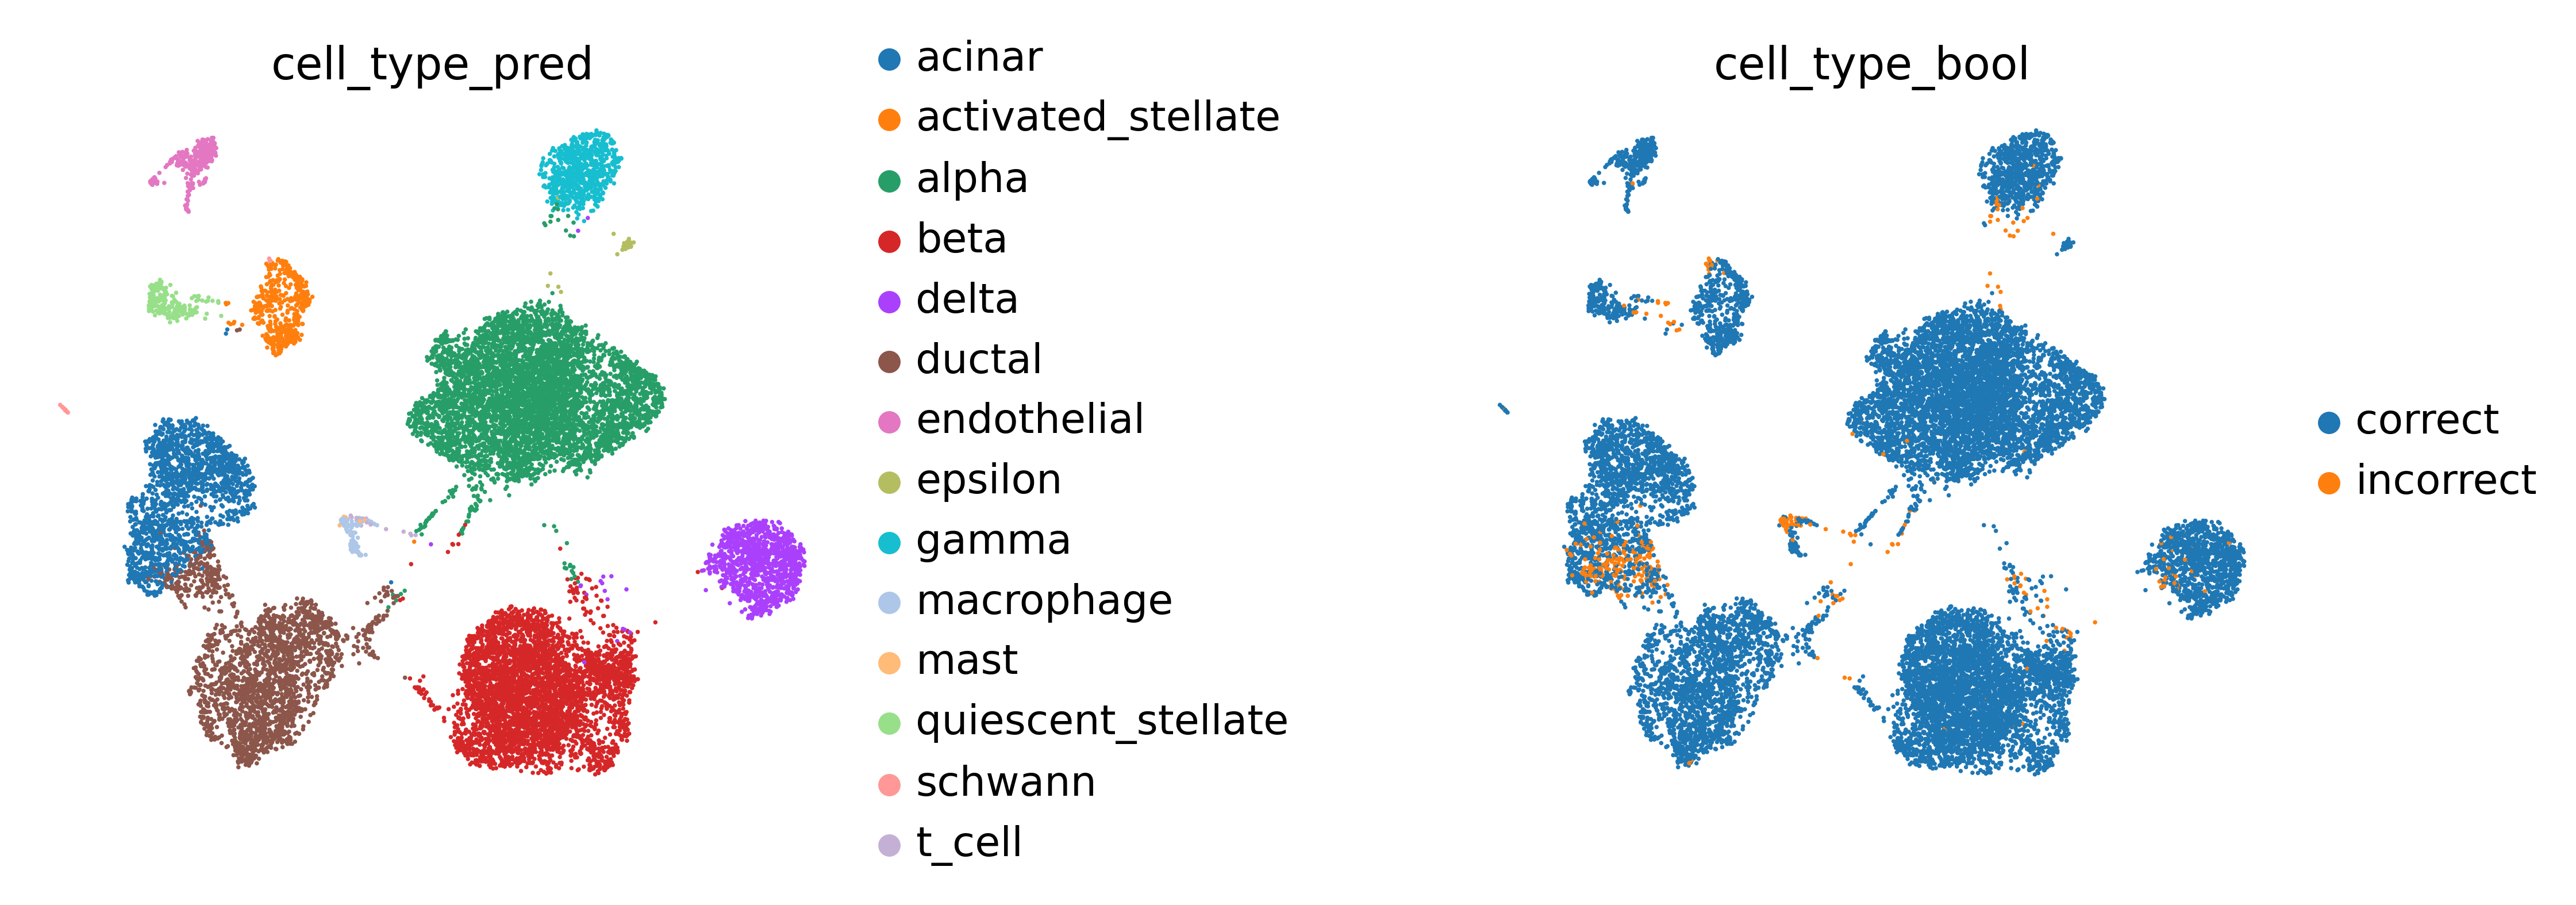

In [26]:
sc.pl.umap(
    adata_latent_wquery,
    color=['cell_type_pred', 'cell_type_bool'],
    wspace=0.6,
    frameon=False
)

In [27]:
f1 = list()
prec = list()
recall = list()
for key in list(results_dict['cell_type']['report'].keys())[:-4]:
    print(key)
    f1.append(results_dict['cell_type']['report'][key]['f1-score'])
    prec.append(results_dict['cell_type']['report'][key]['precision'])
    recall.append(results_dict['cell_type']['report'][key]['recall'])

acinar
activated_stellate
alpha
beta
delta
ductal
endothelial
epsilon
gamma
macrophage
mast
quiescent_stellate
schwann


/home/icb/carlo.dedonno/anaconda3/envs/lataq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'F1 score')

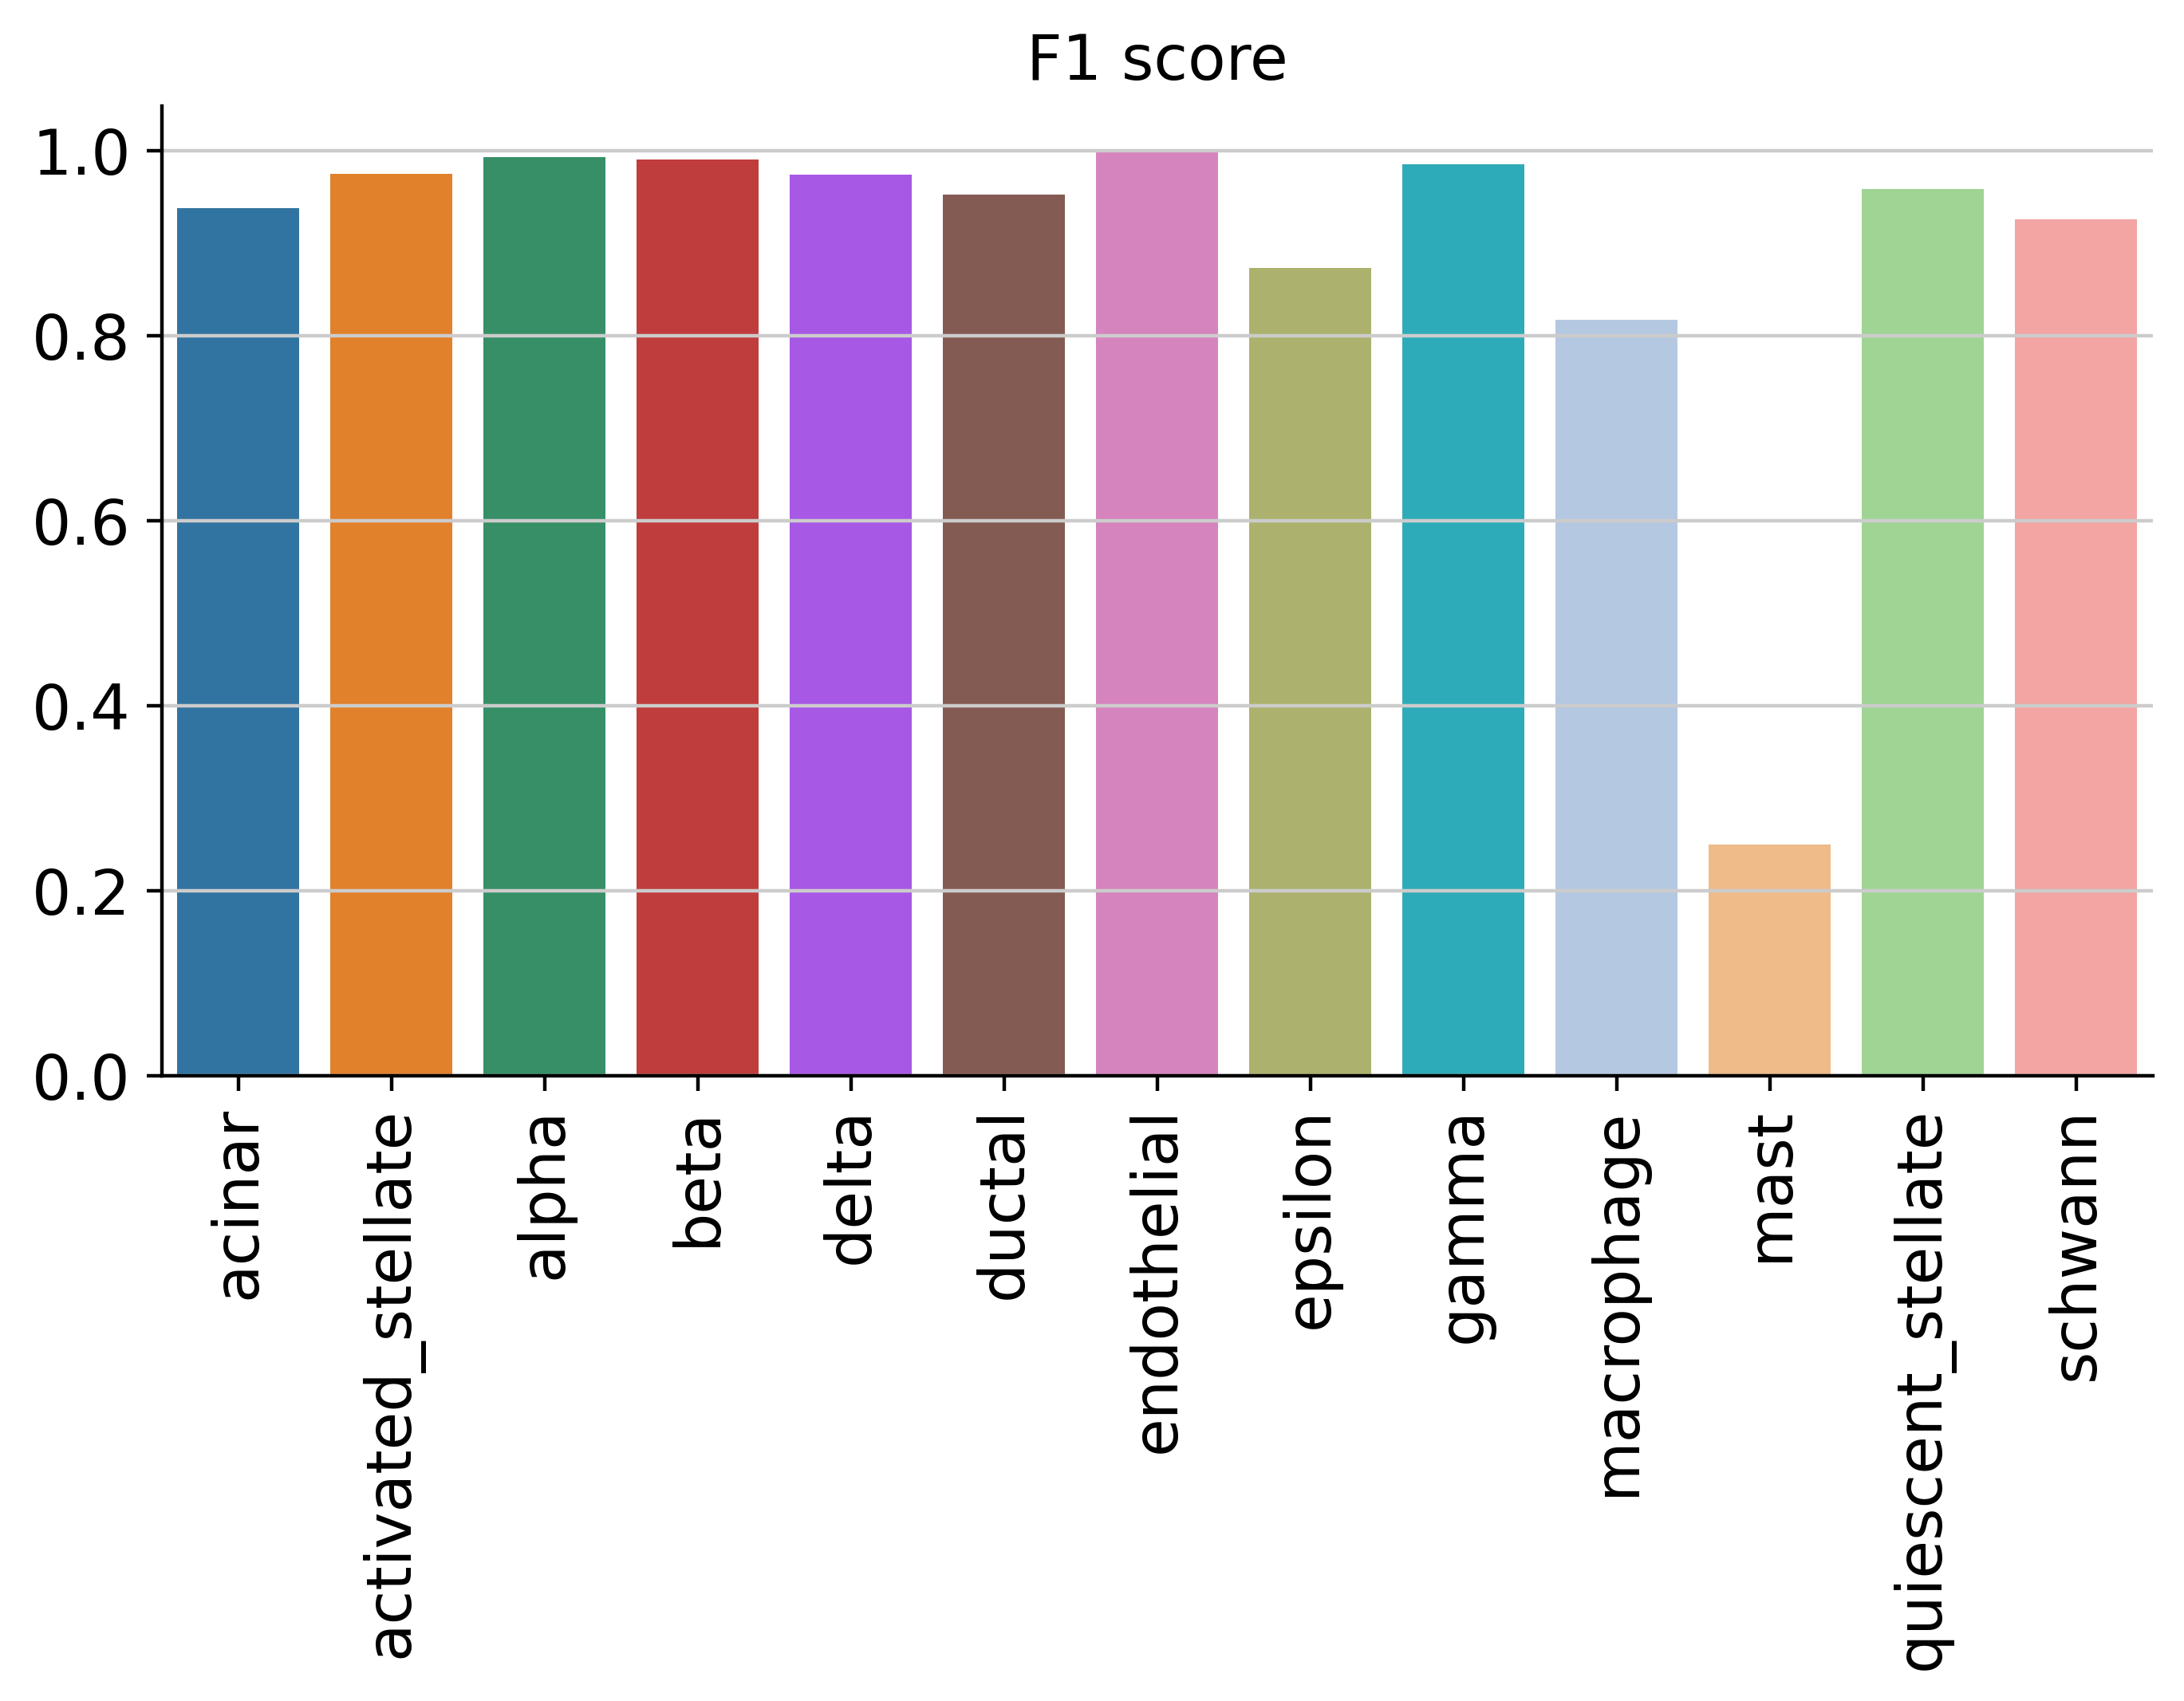

In [28]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    list(results_dict['cell_type']['report'].keys())[:-4],
    f1,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()
ax.set_title('F1 score')

/home/icb/carlo.dedonno/anaconda3/envs/lataq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'precision')

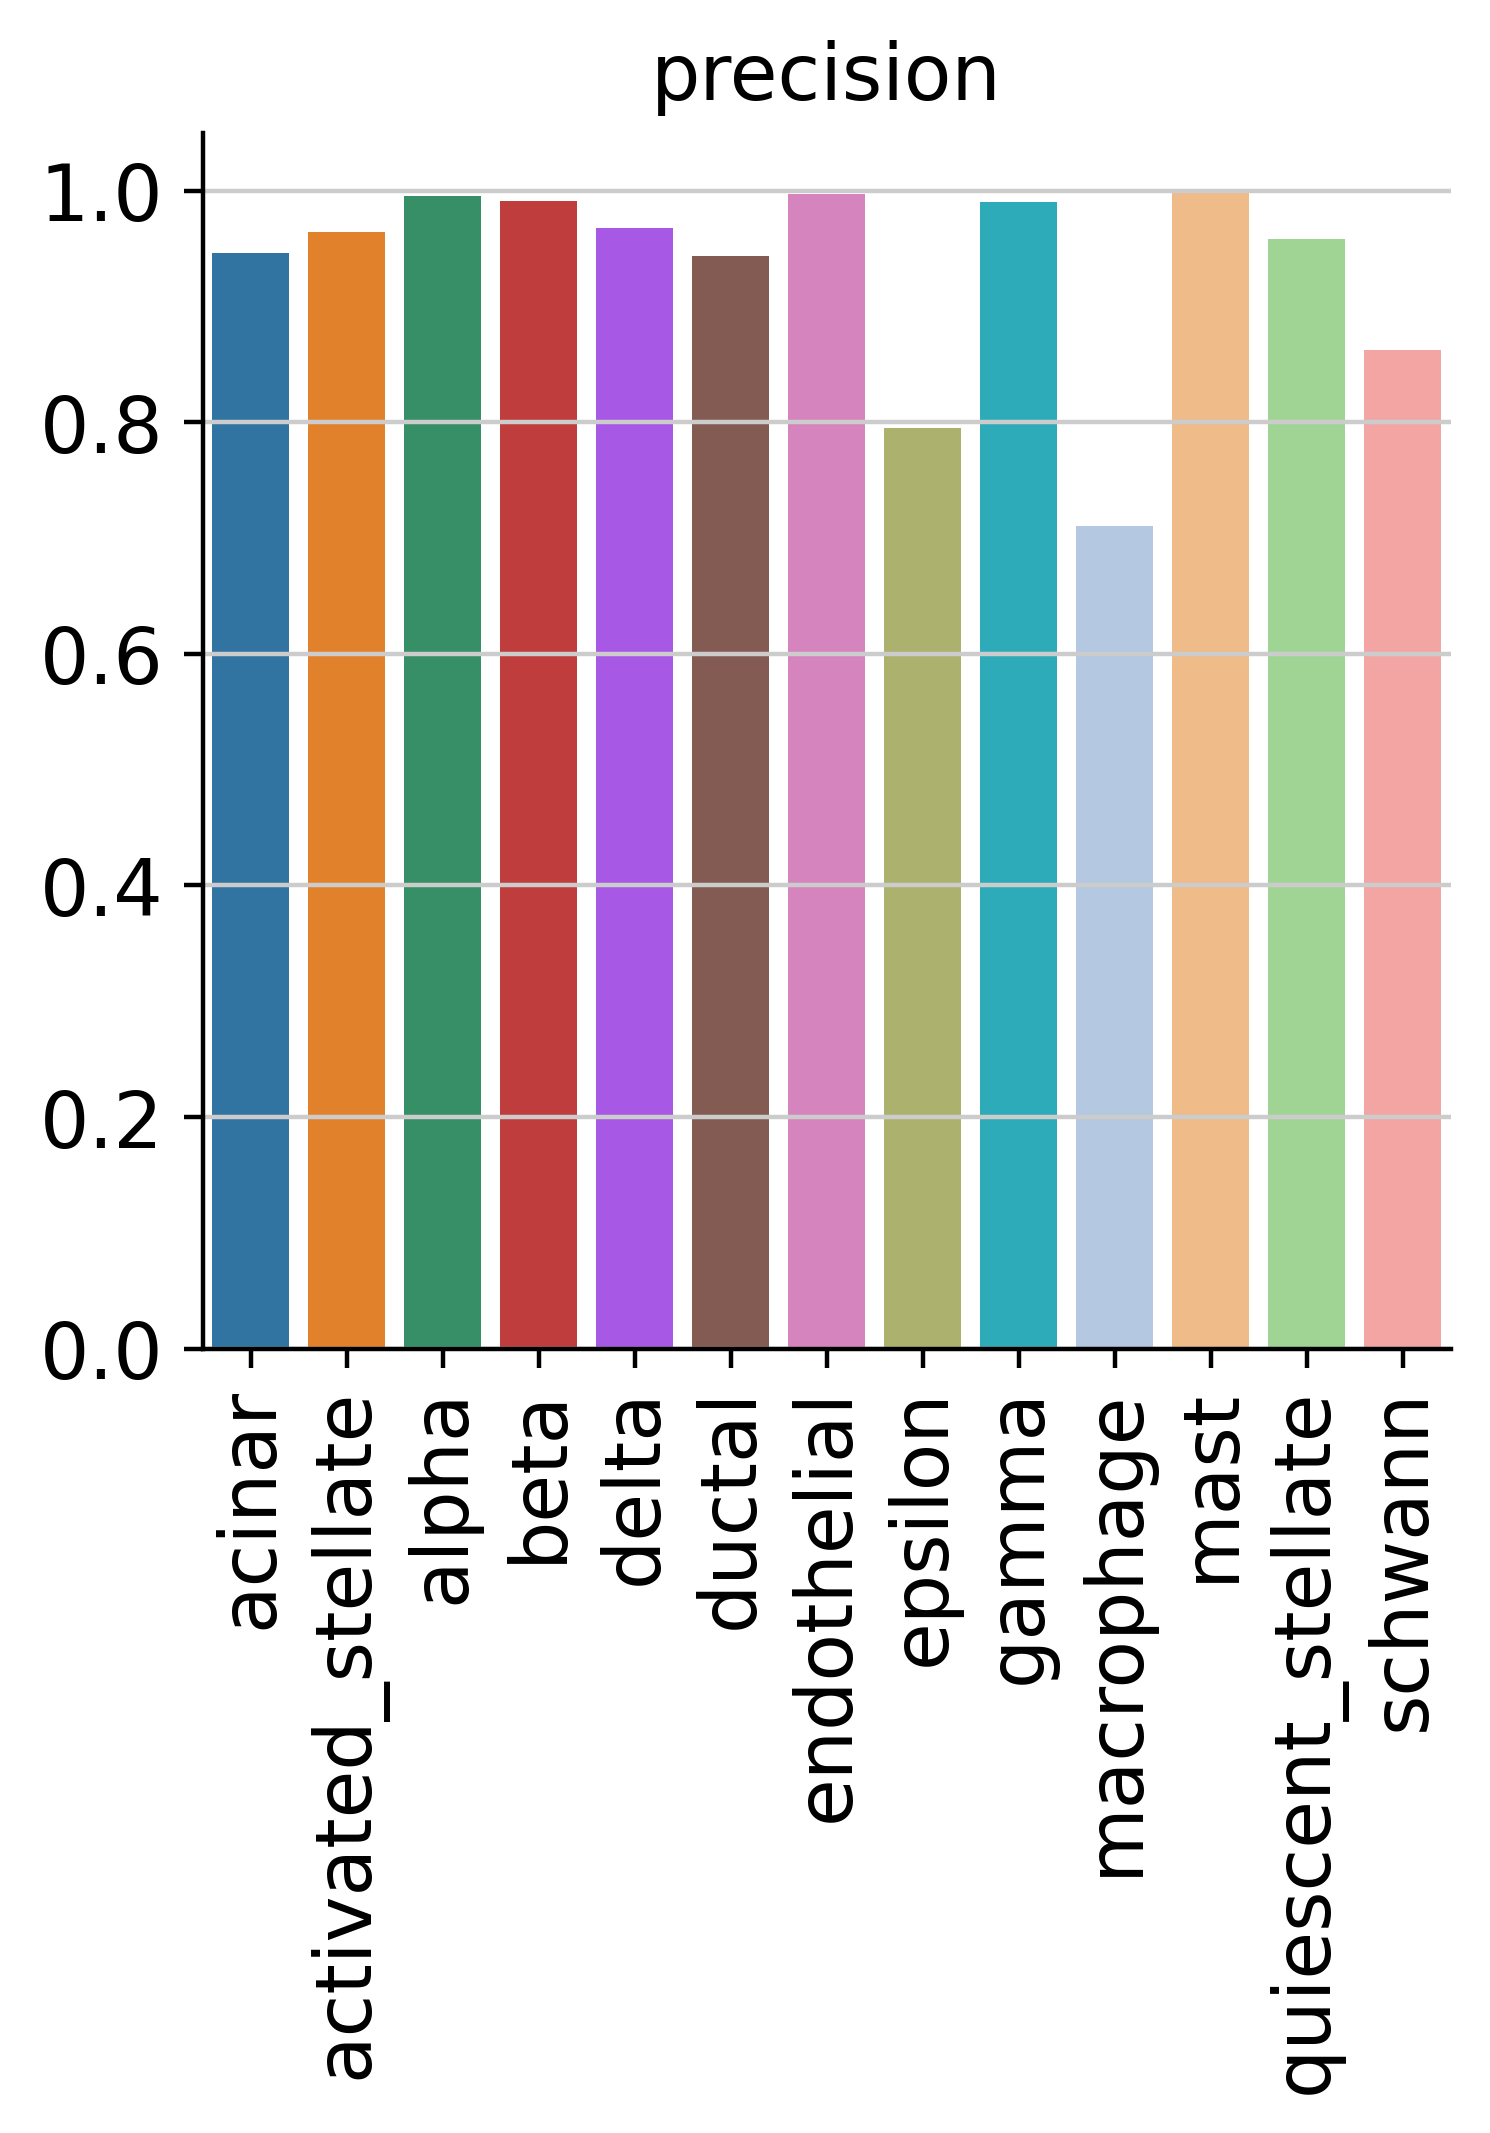

In [29]:
import seaborn as sns
fig, ax = plt.subplots(1, 1)
sns.barplot(
    list(results_dict['cell_type']['report'].keys())[:-4],
    prec,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()
ax.set_title('precision')

/home/icb/carlo.dedonno/anaconda3/envs/lataq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'recall')

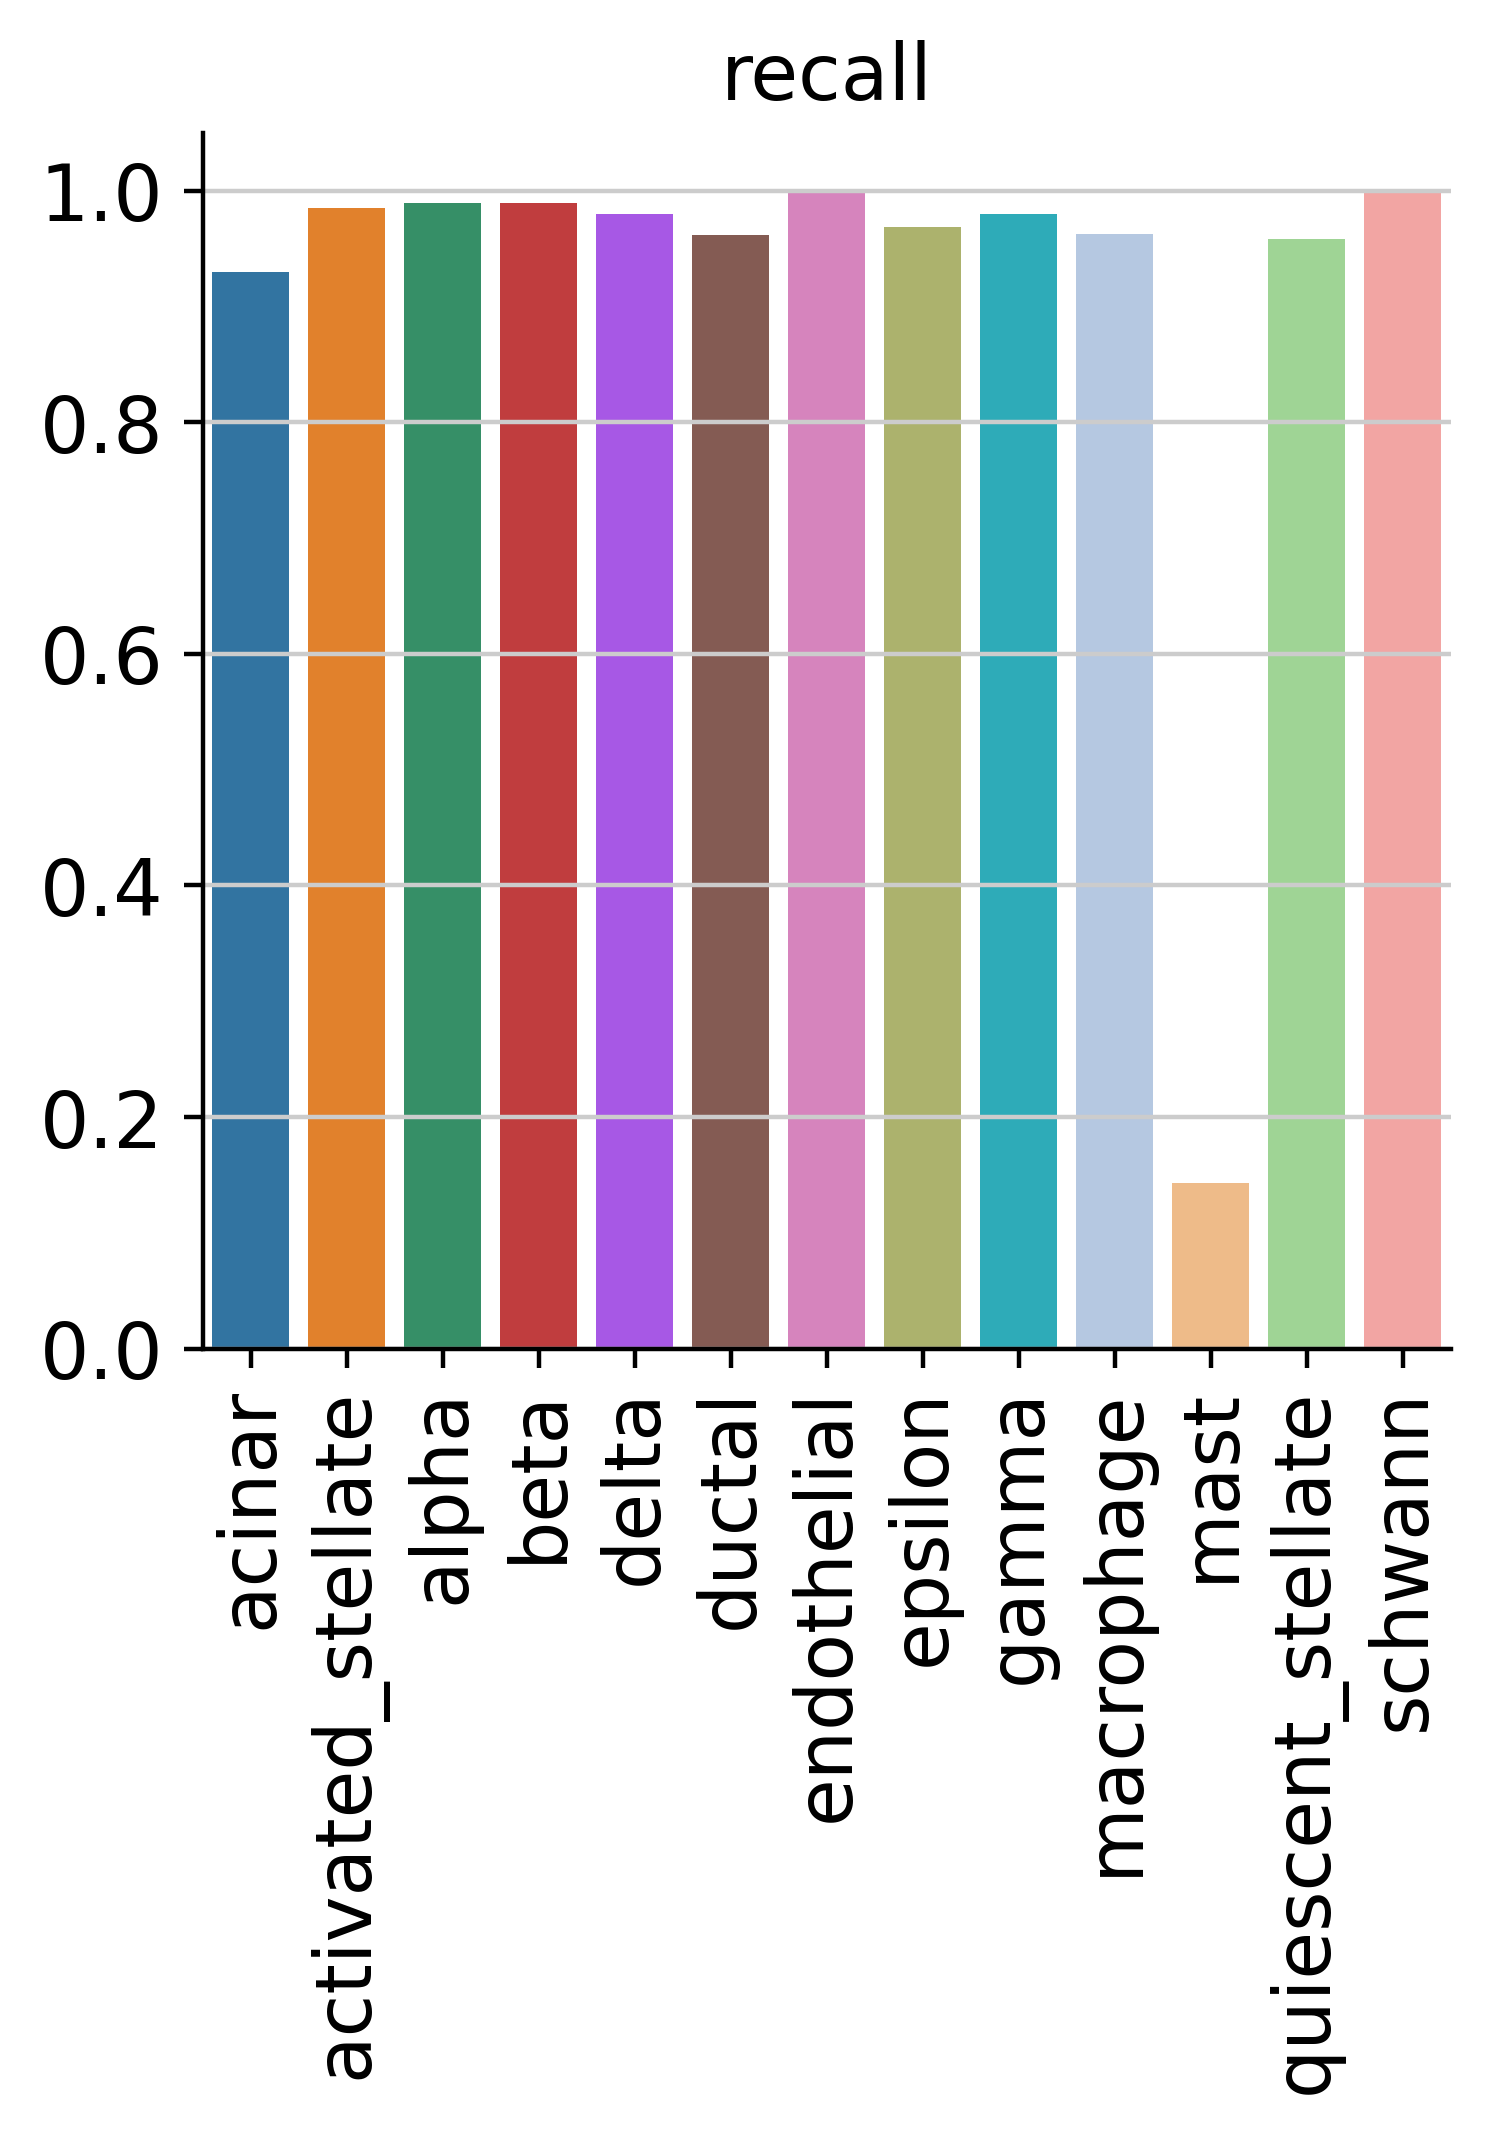

In [30]:
import seaborn as sns
fig, ax = plt.subplots(1, 1)
sns.barplot(
    list(results_dict['cell_type']['report'].keys())[:-4],
    recall,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()
ax.set_title('recall')